In [2]:
import numpy as np
import pandas as pd
from gurobipy import Model, GRB, quicksum
import matplotlib.pyplot as plt

In [3]:
initial_projects = pd.read_csv("InnitialData.csv")

initial_projects['Duration'] = initial_projects['Duration'] -2
initial_projects

,Project,Duration,Expected revenue,Standart deviation
0,Data analytics tools 1,3,3.71,1.13155
1,Customizable reports,3,3.34,0.91850
2,Compatibility with other software,3,3.17,0.86858
3,Data analytics tools 2,2,2.91,0.75078
4,Enhanced administrative tools,2,2.62,0.61046
5,Enhanced user interface,1,1.95,0.46020
6,Social media components,1,1.79,0.39022


In [87]:
def generate_d():
    return np.random.choice(np.array([2, 2, 1, 3]))

def generate_scenarios(m, lambd, alpha, time_horizon):
    durations = [[list(initial_projects['Duration'].values)]]
    eps = [[[np.random.normal(i, j) for i, j in zip(initial_projects['Expected revenue'], initial_projects['Standart deviation'])]]]
    
    for _ in range(time_horizon + 1):
        dur_temp = []
        eps_temp = []
        
        for duration, current_eps in zip(durations, eps):
            for _ in range(m):
                # Generate random durations and calculate updated revenues
                d = [generate_d() for _ in range(4)]
                temp = [np.random.normal(i * lambd, i * alpha) for i in d]
                
                # Append new durations and revenues to scenarios
                dur_temp.append(duration + [d])
                eps_temp.append(current_eps + [temp])
        
        durations = dur_temp
        eps = eps_temp

    return durations, eps

def generate_S_k_t(tilde_xi_k_t_i, time_horizon, number_of_scenarios):
    # Initialize S_k_t as a list of lists for each scenario and time step
    S_k_t = [[[] for _ in range(0, time_horizon + 1)] for _ in range(number_of_scenarios)]

    # Precompute hashes for tilde_xi arrays for efficient comparison
    hashes = [
        {t: hash(tuple(tilde_xi_k_t_i[k][t])) for t in range(1, time_horizon + 1)}
        for k in range(number_of_scenarios)
    ]

    # Compare scenarios to find matching time steps
    for idx in range(number_of_scenarios):
        for i in range(number_of_scenarios):
            if idx != i:  # Avoid comparing a scenario with itself
                for t in range(1, time_horizon + 1):
                    if hashes[idx][t] == hashes[i][t]:
                        S_k_t[idx][t].append(i)
                    else:
                        break  # Stop comparing at the first mismatch
    return S_k_t


def generate_params(durations, eps, time_horizon):

    start = []
    complete = []

    for j, d in enumerate(durations):
        start.extend(np.zeros(len(d))+j)
        complete.extend(np.array(d)+j)

    start = np.array(start).astype(int)
    complete = np.array(complete).astype(int)

    revenue = []
    for j, e in enumerate(eps):
        revenue.extend(e)

    tilde_xi_t_i = np.zeros((time_horizon+1, len(start)))

    for i in range(len(start)):
        if complete[i]<=time_horizon:
            tilde_xi_t_i[complete[i], i] = revenue[i]

    C = [[] for i in range(0, time_horizon + 1)]

    for j, i in enumerate(complete):
        if i<=time_horizon:
            C[i].append(j)

    I = [[] for i in range(0, time_horizon + 1)]

    for i in range(0, time_horizon + 1):
        for j, (s, f) in enumerate(zip(start,complete)):
            if s<=i<=f:
                I[i].append(j)

    T = []

    for s, f in zip(start,complete):
        T.append([t for t in range(s, f+1)])
    
    return C, I, T, tilde_xi_t_i, start

def generate_K_scenario(m, lambd, alpha, time_horizon):
    C_k_t = []
    I_k_t = []
    T_k_i = []
    tilde_xi_k_t_i = []
    s_k_i = []

    durations, eps = generate_scenarios(m, lambd, alpha, time_horizon)
    n = len(durations)

    for i in range(n):
        
        C, I, T, tilde_xi_t_i, s = generate_params(durations[i], eps[i], time_horizon)
        C_k_t.append(C)
        I_k_t.append(I)
        T_k_i.append(T)
        tilde_xi_k_t_i.append(tilde_xi_t_i)
        s_k_i.append(s)
    
    S_k_t = generate_S_k_t(tilde_xi_k_t_i, time_horizon, n)


    return C_k_t, I_k_t, T_k_i, tilde_xi_k_t_i, s_k_i, S_k_t

In [88]:
C_k_t, I_k_t, T_k_i, tilde_xi_k_t_i, s_k_i, S_k_t = generate_K_scenario(2, 0.6, 0.4, 10)

In [104]:
def check_feasibility(R, r, q, p, F, U):

    model = Model("FA_r")
    model.setParam('OutputFlag', 0)

    y = {}
    beta = {}

    for k in range(number_of_scenarios): 
        for t in range(1, r+1):
            for i in I_k_t[k][t]: 
                if t in T_k_i[k][i]:
                    y[k, t, i] = model.addVar(vtype=GRB.BINARY, name=f"y_{k}_{t}_{i}")

    for k in range(number_of_scenarios):
        for t in range(1, r):
            for i in I_k_t[k][t]: 
                if t+1 in T_k_i[k][i]:
                    model.addConstr(y[k, t, i] >= y[k, t + 1, i], 
                                    name=f"TemporalConsistency_k{k}_t{t}_i{i}")

    for k in range(number_of_scenarios):
        for t in range(1, r + 1):  # Adjust this range to `s_i` to `r` if needed
            for i in I_k_t[k][t]:  # Iterate over `i` in the index set  
                if t >= s_k_i[k][i]:
                    for k_prime in S_k_t[k][t]:  
                            model.addConstr(y[k, t, i] == y[k_prime, t, i], 
                                            name=f"NonAnticipativity_k{k}_kprime{k_prime}_t{t}_i{i}")
                        
    for k in range(number_of_scenarios): 
        for t in range(1, r + 1): 
                model.addConstr(quicksum(y[k, t, i] for i in I_k_t[k][t]) <= U, name=f"CapacityConstraint_k{k}_t{t}")

    for k in range(number_of_scenarios):
        beta[k] = model.addVar(vtype=GRB.BINARY, name=f"beta_{k}")

    model.addConstr(
        quicksum(q * beta[k] for k in range(number_of_scenarios)) >= p,
        name="ProbabilityThreshold"
    )

    for k in range(number_of_scenarios):  # Loop over scenarios
        lhs = quicksum(
            y[k, t, i] * tilde_xi_k_t_i[k][t][i]  # Accumulated return
            for t in range(3, r + 1)
            for i in C_k_t[k][t]
        ) - r * F  # Subtract fixed cost

        rhs = (
            R * beta[k] + (1 - beta[k]) *(-1)  # Penalty
        )

        model.addConstr(lhs >= rhs, name=f"ReturnLevel_k{k}")

    # Set dummy objective
    model.setObjective(0, GRB.MINIMIZE)

    # Solve the model
    model.optimize()

    if not model.Status == GRB.INFEASIBLE:
        return True
    else:
        return False


In [ ]:
def expected_value_problem(tau, q, F, U):

    model = Model("EAM")
    model.setParam('OutputFlag', 0)

    y = {}

    for k in range(number_of_scenarios): 
        for t in range(1, tau+1):
            for i in I_k_t[k][t]: 
                if t in T_k_i[k][i]:
                    y[k, t, i] = model.addVar(vtype=GRB.BINARY, name=f"y_{k}_{t}_{i}")

    for k in range(number_of_scenarios):
        for t in range(1, tau):
            for i in I_k_t[k][t]: 
                if t+1 in T_k_i[k][i]:
                    model.addConstr(y[k, t, i] >= y[k, t + 1, i], 
                                    name=f"TemporalConsistency_k{k}_t{t}_i{i}")

    for k in range(number_of_scenarios):
        for t in range(1, tau + 1):  # Adjust this range to `s_i` to `r` if needed
            for i in I_k_t[k][t]:  # Iterate over `i` in the index set  
                if t >= s_k_i[k][i]: 
                    for k_prime in S_k_t[k][t]: 
                            model.addConstr(y[k, t, i] == y[k_prime, t, i], 
                                            name=f"NonAnticipativity_k{k}_kprime{k_prime}_t{t}_i{i}")
                        
    for k in range(number_of_scenarios): 
        for t in range(1, tau + 1): 
                model.addConstr(quicksum(y[k, t, i] for i in I_k_t[k][t]) <= U, name=f"CapacityConstraint_k{k}_t{t}")
    
    objective = quicksum(
        q * y[k, tau, i] * tilde_xi_k_t_i[k][tau][i]  # Weighted reward
        for k in range(number_of_scenarios)  # Over all scenarios
        for i in C_k_t[k][tau]  # Over all projects completing at tau_star
    ) - tau * F  # Subtract fixed cost

    # Set the objective in the model
    model.setObjective(objective, GRB.MAXIMIZE)

    # Solve the model
    model.optimize()

    if model.Status == GRB.OPTIMAL:
        print("Innitial upper-bound", model.objVal)
        return model.objVal
    else:
        print("The model did not converge to an optimal solution.")
        return None

In [106]:
def check_F_W_tau(tau, R_v, q, F, U, p, solution = False):
    
    model = Model("EAM")
    model.setParam('OutputFlag', 0)

    y = {}
    beta = {}

    for k in range(number_of_scenarios): 
        for t in range(1, tau+1):
            for i in I_k_t[k][t]: 
                if t in T_k_i[k][i]:
                    y[k, t, i] = model.addVar(vtype=GRB.BINARY, name=f"y_{k}_{t}_{i}")

    for k in range(number_of_scenarios):
        for t in range(1, tau):
            for i in I_k_t[k][t]: 
                if t+1 in T_k_i[k][i]:
                    model.addConstr(y[k, t, i] >= y[k, t + 1, i], 
                                name=f"TemporalConsistency_k{k}_t{t}_i{i}")

    for k in range(number_of_scenarios):
        for t in range(1, tau + 1):  # Adjust this range to `s_i` to `r` if needed
            for i in I_k_t[k][t]:  # Iterate over `i` in the index set  
                if t >= s_k_i[k][i]: 
                    for k_prime in S_k_t[k][t]: 
                        model.addConstr(y[k, t, i] == y[k_prime, t, i], name=f"NonAnticipativity_k{k}_kprime{k_prime}_t{t}_i{i}")
                            
    for k in range(number_of_scenarios): 
        for t in range(1, tau + 1): 
                model.addConstr(quicksum(y[k, t, i] for i in I_k_t[k][t]) <= U, name=f"CapacityConstraint_k{k}_t{t}")
    
    for k in range(number_of_scenarios):
        beta[k] = model.addVar(vtype=GRB.BINARY, name=f"beta_{k}")

    model.addConstr(
        quicksum(q * beta[k] for k in range(number_of_scenarios)) >= p,
        name="ProbabilityThreshold"
    )

    for k in range(number_of_scenarios):  # Loop over scenarios
        # Compute LHS: Accumulated return minus fixed cost
        lhs = quicksum(
            y[k, tau, i] * tilde_xi_k_t_i[k][tau][i] for i in C_k_t[k][tau]
        ) - tau * F
        # Compute RHS: Return level or penalty term
        rhs = (
            R_v * beta[k]  # Return level achieved
            + (1 - beta[k]) * (-1 * tau)  # Penalty
        )

        # Add the constraint
        model.addConstr(lhs >= rhs, name=f"ReturnLevelConstraint_k{k}")

    
    # Set dummy objective
    model.setObjective(0, GRB.MINIMIZE)

    # Solve the model
    model.optimize()
    if not model.Status == GRB.INFEASIBLE:

        if solution:
            solution_beta = {}
            solution_y = {}
            for k in range(number_of_scenarios):
                solution_beta[k] = beta[k].x
                solution_y[k] = {}
                for t in range(1, tau + 1):
                    for i in I_k_t[k][t]:
                        solution_y[k][t, i] = y[k, t, i].x
            return solution_y, solution_beta
        
        return True
    else:
        return False

    

In [148]:
def get_first_upper(l_v):
    for tau in range(3, time_horizon+1):
        print(tau)
        feasible = check_feasibility(l_v, tau, q, p, F, U)
        if feasible:
            print(f"For t={tau} is feasible.")
            u_v = expected_value_problem(tau, q, F, U)
            return u_v, tau

In [108]:
def bisection_method(l_v, eps):

    u_v, tau = get_first_upper(l_v)

    if u_v<l_v:
        print("Something went wrong")
        return
    
    counter = 1

    print(f"---------------------")

    while (u_v - l_v >= eps):

        print(f"Iteration: {counter}")
        print(f"Lower bound: {l_v}")
        print(f"Upper bound: {u_v}")
        print(f"---------------------")

        R_v = (l_v + u_v)/2

        if check_F_W_tau(tau, R_v, q, F, U, p):
            l_v = R_v
        else:
            u_v = R_v

        
        counter+=1

    return tau, l_v


In [165]:
target_R = 20
U = 100
eps = 0.001

time_horizon  = 7
lambd = 0.65
alpha = 0.4

p = 0.9
F = 0.3


m = 2
C_k_t, I_k_t, T_k_i, tilde_xi_k_t_i, s_k_i, S_k_t = generate_K_scenario(m, lambd, alpha, time_horizon)
number_of_scenarios = len(C_k_t)
q = 1/number_of_scenarios


In [169]:
t_star, R_star = bisection_method(target_R, eps)
solution_y, solution_beta = check_F_W_tau(t_star, R_star, q, F, U, p, solution = True)

3
4
5
6
For t=6 is feasible.


KeyError: (0, 1, 15)

In [117]:
def return_project_portfolios(solution_y):
    T = []
    for idx in range(number_of_scenarios):

        t = [[] for i in range(0, t_star+1)]

        for j in solution_y[idx].keys():
            if solution_y[idx][j]!=0:
                t[j[0]].append(j[1])
        T.append(t[1: t_star+1])
    return T

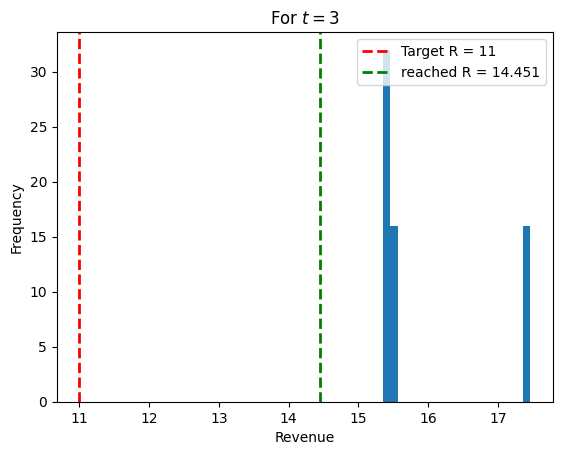

In [122]:
R = []

for idx in range(number_of_scenarios):

    t = [[] for i in range(0, t_star+1)]

    for j in solution_y[idx].keys():
        if solution_y[idx][j]!=0:
            t[j[0]].append(j[1])

    R.append(sum([sum(tilde_xi_k_t_i[idx][i][t[i]]) for i in range(3, t_star+1)])) 
    

plt.hist(R, bins=20)  # 20 columns (bins)
plt.xlabel('Revenue')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.title(f'For $t = {t_star}$')  # Title of the plot
plt.axvline(target_R, color='red', linestyle='--', linewidth=2, label=f'Target R = {target_R}') # X-axis label
plt.axvline(R_star, color='green', linestyle='--', linewidth=2, label=f'reached R = {np.round(R_star, 3)}') # X-axis label
plt.legend()
plt.show()


In [51]:
total_projects = len(s_k_i[0])
prob = np.zeros((t_star, total_projects))

In [52]:
T = return_project_portfolios(solution_y)

for i in T:
    for time, j in enumerate(i):
        for k in j:
            prob[time][k] += 1/number_of_scenarios

In [ ]:
for t in range(1, t_star+1):
    idx = np.arange(total_projects)[prob[t-1]>0]
    print(f"In period {t}")
    text=""
    counter = 0
    for i,j in zip(prob[t-1][idx], idx):
        text+=f"p({j}) = {np.round(i, 2)} "
        counter+=1
        if counter%8 == 0:
            text+="\n"
    print(text)
    print()

In period 1
p(0) = 1.0 p(1) = 1.0 p(2) = 1.0 p(3) = 1.0 p(4) = 1.0 p(5) = 1.0 p(6) = 1.0 p(7) = 1.0 
p(8) = 1.0 p(9) = 1.0 p(10) = 1.0 

In period 2
p(0) = 1.0 p(1) = 1.0 p(2) = 1.0 p(7) = 1.0 p(8) = 1.0 p(9) = 1.0 p(10) = 1.0 p(11) = 1.0 
p(12) = 1.0 p(13) = 1.0 p(14) = 1.0 

In period 3
p(0) = 1.0 p(1) = 1.0 p(2) = 1.0 p(7) = 0.19 p(8) = 0.28 p(9) = 0.24 p(10) = 0.21 p(11) = 0.26 
p(12) = 0.22 p(13) = 0.24 p(14) = 0.27 p(15) = 1.0 p(16) = 1.0 p(17) = 1.0 p(18) = 1.0 

In period 4
p(0) = 0.9 p(1) = 0.87 p(2) = 0.89 p(7) = 0.18 p(8) = 0.28 p(9) = 0.23 p(10) = 0.2 p(11) = 0.25 
p(12) = 0.21 p(13) = 0.23 p(14) = 0.26 

In period 5
p(0) = 0.89 p(1) = 0.87 p(2) = 0.87 p(7) = 0.18 p(8) = 0.28 p(9) = 0.23 p(10) = 0.2 p(11) = 0.23 
p(12) = 0.21 p(13) = 0.23 p(14) = 0.25 



In [27]:
T

NameError: name 'T' is not defined